In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import requests

## ARTSUTVALG

In [2]:
arter = pd.read_excel('c:\data\AlleRødlistearterNiNKonvertert_Alle nivå.xlsx', sheet_name='Tilstand', skiprows = 1)

In [3]:
arter = arter[['EkspertGruppe','PopularNavn','VitenskapligNavn','PK_RodlistevurderingID','Tresjiktssuksesjonstilstand',	'Gammelskog']]
arter.head()

,EkspertGruppe,PopularNavn,VitenskapligNavn,PK_RodlistevurderingID,Tresjiktssuksesjonstilstand,Gammelskog
0,Alger,NaN,Asperococcus ensiformis,19013,NaN,NaN
1,Alger,ishavsbelte,Coilodesme bulligera,19022,NaN,NaN
2,Alger,dypvannsbrunblad,Omphalophyllum ulvaceum,19068,NaN,NaN
3,Alger,gaffeltrevl,Sphaerotrichia divaricata,19077,NaN,NaN
4,Alger,knippetråd,Delamarea attenuata,19090,NaN,NaN


In [4]:
RL21 = pd.read_excel('c:/data/RLA 2021.xlsx')

In [5]:
# Begrenser utvalget til arter som har en gammelskogverdi og som tilhører en av ekspertgruppene sopp, lav eller karplanter
utvalgsarter = arter[~arter['Gammelskog'].isna()][arter['EkspertGruppe'].isin(['Sopp','Lav','Karplanter'])]
# Legger til RL21 informasjon
utvalgsarter = pd.merge(RL21[['VurderingsId2010', 'NorskNavn','Kategori2021']],utvalgsarter, left_on='VurderingsId2010', right_on='PK_RodlistevurderingID', how = 'right')

utvalgsarter = utvalgsarter[~utvalgsarter['Kategori2021'].isin(['LC','NE'])][~utvalgsarter['Kategori2021'].isna()]


C:\Users\endofs\AppData\Local\Temp\ipykernel_39248\1202938853.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  utvalgsarter = arter[~arter['Gammelskog'].isna()][arter['EkspertGruppe'].isin(['Sopp','Lav','Karplanter'])]
C:\Users\endofs\AppData\Local\Temp\ipykernel_39248\1202938853.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  utvalgsarter = utvalgsarter[~utvalgsarter['Kategori2021'].isin(['LC','NE'])][~utvalgsarter['Kategori2021'].isna()]


In [6]:
utvalg = utvalgsarter['VitenskapligNavn'].tolist()
utvalgsarter['Kategori2021'].value_counts()

Kategori2021
VU     80
NT     69
EN     63
DD     18
CR      6
NTº     3
VUº     1
Name: count, dtype: int64

## GBIF

In [7]:
# set up request function
import requests
import pandas as pd
base_url = "https://api.gbif.org/v1/occurrence/search?"
countryCode = "NO"
def get_GBIF_response(base_url, offset, params, df, maxCount = None, i = None):
    """Performs an API call to the base URL with additional parameters listed in 'params'. Concatenates response to a Pandas DataFrame, 'df'."""
    
    #Construct the query URL
    query = base_url+'&'+f'offset={offset}'
    for each in params:
        query = query+'&'+each
            
    #Call API
    #print(query)
    response = requests.get(query)
    
    #If call is successful, add data to df
    if response.status_code != 200:
        print(f"API call failed at offset {offset} with a status code of {response.status_code}.")
    else:
        result = response.json()
        df2 = pd.DataFrame.from_dict(result['results'])
        if i is not None:
            df2['query'] = i
        df_concat = pd.concat([df, df2], axis = 0, ignore_index = True, sort = True)
        endOfRecords = result['endOfRecords']
        return df_concat, endOfRecords, response.status_code
#set parameters for API call
#params0 = ['limit=100', 'publishingCountry=NO','hasGeospatialIssue=false', 'hasCoordinate=true','year=2010,2025','coordinateUncertaintyInMeters=0,100', 'county=Trøndelag']
base_params = ['publishingCountry=NO','hasGeospatialIssue=false', 'hasCoordinate=true','coordinateUncertaintyInMeters=0,100']

In [8]:
print(utvalg)

['Biatoridium monasteriense', 'Strangospora ochrophora', 'Cliostomum corrugatum', 'Ramalina obtusata', 'Ramalina sinensis', 'Ramalina thrausta', 'Alectoria sarmentosa', 'Bryoria bicolor', 'Bryoria nadvornikiana', 'Bryoria smithii', 'Bryoria tenuis', 'Evernia divaricata', 'Evernia mesomorpha', 'Hypotrachyna laevigata', 'Hypotrachyna sinuosa', 'Letharia vulpina', 'Parmotrema arnoldii', 'Parmotrema crinitum', 'Usnea florida', 'Usnea glabrata', 'Usnea longissima', 'Heterodermia speciosa', 'Phaeophyscia kairamoi', 'Calicium denigratum', 'Calicium lenticulare', 'Cyphelium karelicum', 'Cyphelium pinicola', 'Cladonia parasitica', 'Hypocenomyce anthracophila', 'Hypocenomyce castaneocinerea', 'Gyalecta flotowii', 'Gyalecta friesii', 'Gyalecta truncigena', 'Gyalecta ulmi', 'Dimerella lutea', 'Caloplaca chrysophthalma', 'Caloplaca lucifuga', 'Collema conglomeratum', 'Collema occultatum', 'Leptogium burgessii', 'Leptogium cochleatum', 'Chaenothecopsis fennica', 'Sphinctrina turbinata', 'Arthonia ci

In [ ]:
import os
import time
import pandas as pd

years = range(2020,2024)
species = utvalg#[0:2]
df = pd.DataFrame()
endOfRecords = False
i = 0
offset = 0
status = 200

output_file = 'G:/temp/endre/naturskog/GBIF_gammelskog.csv'
log_file = 'G:/temp/endre/naturskog/GBIF_gammelskog_log.csv'

for specie in species:
    params1 = base_params + [f'scientificName={specie}']
    for year in years:
        params = params1 + [f'year={year}']
        params_string = '&'.join(params)
        
        # Check if query already completed
        skip_query = False
        if os.path.exists(log_file):
            with open(log_file, 'r') as f:
                if params_string in f.read():
                    print(f"Skipping {specie} in {year} - already processed")
                    skip_query = True
        
        if not skip_query:
            while endOfRecords == False and status == 200:
                df, endOfRecords, status = get_GBIF_response(base_url, offset, params, df, i=specie, maxCount=100)
                endOfRecords = True
                print(offset)
                offset = len(df) + 1
            
            endOfRecords = False
            offset = 0
            status = 200
            
            if i==0:
                mode = 'w' if not os.path.exists(output_file) else 'a'
                header = not os.path.exists(output_file)
            else:
                mode = 'a'
                header = False
                
            df.to_csv(output_file, mode=mode, header=header, index=False)
            
            with open(log_file, mode) as f:
                f.write(f"{params_string}\n")
            
            print(f"Data for {specie} in {year} has been collected.")    
            time.sleep(10)

Skipping Biatoridium monasteriense in 2020 - already processed
Skipping Biatoridium monasteriense in 2021 - already processed
Skipping Biatoridium monasteriense in 2022 - already processed
Skipping Biatoridium monasteriense in 2023 - already processed
Skipping Strangospora ochrophora in 2020 - already processed
Skipping Strangospora ochrophora in 2021 - already processed
Skipping Strangospora ochrophora in 2022 - already processed
Skipping Strangospora ochrophora in 2023 - already processed
Skipping Cliostomum corrugatum in 2020 - already processed
Skipping Cliostomum corrugatum in 2021 - already processed
Skipping Cliostomum corrugatum in 2022 - already processed
Skipping Cliostomum corrugatum in 2023 - already processed
Skipping Ramalina obtusata in 2020 - already processed
Skipping Ramalina obtusata in 2021 - already processed
Skipping Ramalina obtusata in 2022 - already processed
Skipping Ramalina obtusata in 2023 - already processed
Skipping Ramalina sinensis in 2020 - already pro

ConnectionError: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))

Paralle-version-attempt

In [ ]:
import os
import time
import pandas as pd
from concurrent.futures import ThreadPoolExecutor
import requests
from requests.exceptions import ConnectionError, Timeout

years = range(2010, 2020)
species = utvalg#[0:2]
output_file = 'G:/temp/endre/naturskog/GBIF_gammelskog.csv'
log_file = 'G:/temp/endre/naturskog/GBIF_gammelskog_log.csv'

def get_GBIF_response(base_url, offset, params, df, i, maxCount=100):
    query = f"{base_url}?offset={offset}&limit={maxCount}&" + "&".join(params)
    retries = 5
    for attempt in range(retries):
        try:
            response = requests.get(query)
            if response.status_code == 200:
                # Process the response and update df, endOfRecords, status
                # This is a placeholder for your actual response processing logic
                data = response.json()
                if isinstance(data, list):
                    new_df = pd.DataFrame(data)
                else:
                    new_df = pd.DataFrame([data])
                df = pd.concat([df, new_df], ignore_index=True)
                endOfRecords = len(new_df) < maxCount
                status = response.status_code
                return df, endOfRecords, status
            else:
                response.raise_for_status()
        except (ConnectionError, Timeout) as e:
            print(f"Attempt {attempt + 1} failed: {e}")
            time.sleep(2 ** attempt)  # Exponential backoff
    raise ConnectionError(f"Failed to get response after {retries} attempts")

def process_species_year(specie, year):
    df = pd.DataFrame()
    endOfRecords = False
    offset = 0
    status = 200
    params1 = base_params + [f'scientificName={specie}']
    params = params1 + [f'year={year}']
    params_string = '&'.join(params)
    
    # Check if query already completed
    skip_query = False
    if os.path.exists(log_file):
        with open(log_file, 'r') as f:
            if params_string in f.read():
                print(f"Skipping {specie} in {year} - already processed")
                skip_query = True
    
    if not skip_query:
        while endOfRecords == False and status == 200:
            df, endOfRecords, status = get_GBIF_response(base_url, offset, params, df, i=specie, maxCount=100)
            endOfRecords = True
            print(offset)
            offset = len(df) + 1
        
        if not df.empty:
            mode = 'a' if os.path.exists(output_file) else 'w'
            header = not os.path.exists(output_file)
            df.to_csv(output_file, mode=mode, header=header, index=False)
        
        with open(log_file, 'a') as f:
            f.write(f"{params_string}\n")
        
        print(f"Data for {specie} in {year} has been collected.")
        time.sleep(5)

# Parallel processing
with ThreadPoolExecutor(max_workers=4) as executor:
    futures = []
    for specie in species:
        for year in years:
            futures.append(executor.submit(process_species_year, specie, year))
    
    for future in futures:
        future.result()  # Wait for all threads to complete

Skipping Strangospora ochrophora in 2010 - already processed
0
0
0
Data for Strangospora ochrophora in 2011 has been collected.
Data for Biatoridium monasteriense in 2010 has been collected.
Data for Biatoridium monasteriense in 2011 has been collected.


Original

In [ ]:
#Set up a simple while loop to continue downloading until the last #page
df = pd.DataFrame()
endOfRecords = False
offset = 0
status = 200
# species to check
species = utvalg#[5:10]
# prefix for the request parameter
pre = 'scientificName='

for i in species:
    print(i)
    params = params0.copy()
    params.append(pre+i)
    while endOfRecords == False and status == 200:
        df, endOfRecords, status = get_GBIF_response(base_url, offset, params, df, i = i,maxCount = 100)
        endOfRecords = True # kommenterer bort denne når jeg vil begrense antall treff, og ikke ha alt
        print(offset)
        offset = len(df) + 1
    endOfRecords = False
    offset = 0
    status = 200

In [9]:
utvalg[0:2]

['Biatoridium monasteriense', 'Strangospora ochrophora']

In [89]:
import geopandas as gpd
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['decimalLongitude'], df['decimalLatitude']), crs = 'EPSG:4326')
gdf = gdf.query('decimalLongitude > 0 & decimalLatitude > 55 & coordinateUncertaintyInMeters<250')
gdf = gdf.merge(utvalgsarter, left_on = 'query', right_on = 'VitenskapligNavn', how = 'left')
gdf = gdf.to_crs('EPSG:25833')
#gdf = gdf.sort_values(by = 'KA_Skilletrinn') 

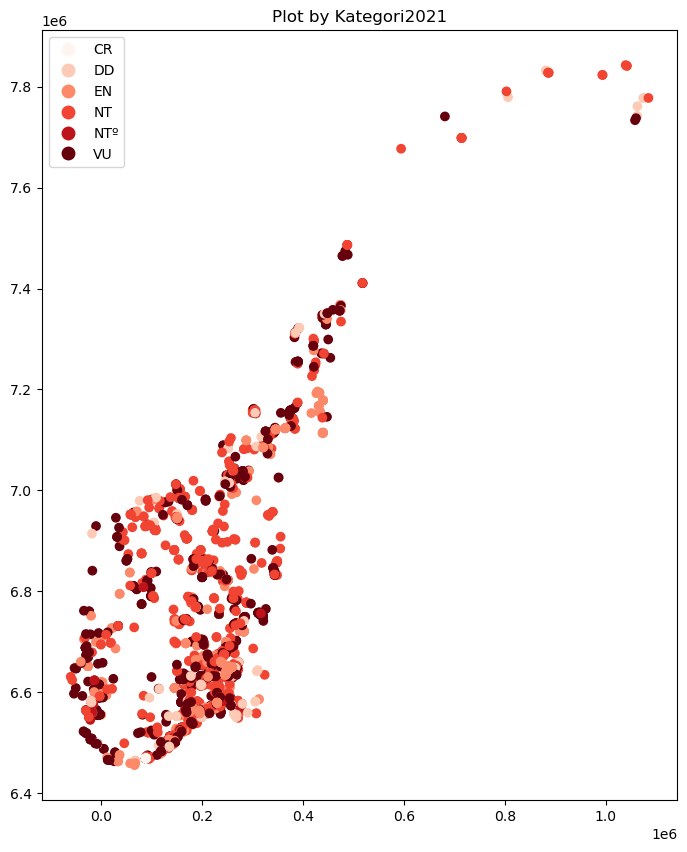

In [90]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Assuming you have a GeoDataFrame named 'gdf' with the column 'KA_Skilletrinn'
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
gdf[gdf['countryCode']=="NO"].plot(column='Kategori2021', cmap='Reds', legend=True, ax=ax)
plt.title('Plot by Kategori2021')
plt.show()


In [4]:
import rasterio
#rasterio.open('c:/data/Trondheim_1m.tif')
nsann = "c:/data/naturskog_v1_naturskogssannsynlighet.tif"

In [6]:
import rasterio
import geopandas as gpd
import numpy as np
from scipy import ndimage
from rasterio.transform import rowcol
import matplotlib.pyplot as plt
from rasterio.mask import mask
#import contextily as ctx

def calculate_neighbor_sums(raster_path, points_gdf, neighborhood_size=3):
    """
    Calculate sum of raster values in neighborhood of points
    Args:
        raster_path: Path to raster file
        points_gdf: GeoDataFrame with points
        neighborhood_size: Size of square neighborhood (odd number, default 3)
    """
    # Validate neighborhood size
    if neighborhood_size % 2 == 0:
        raise ValueError("neighborhood_size must be odd")
    if neighborhood_size < 1:
        raise ValueError("neighborhood_size must be positive")
    
    # Calculate offset for neighborhood
    offset = neighborhood_size // 2
    
    original_crs = points_gdf.crs
    
    with rasterio.open(raster_path) as src:
        if points_gdf.crs != src.crs:
            print(f"Converting points from {points_gdf.crs} to {src.crs}")
            points_gdf = points_gdf.to_crs(src.crs)
        
        raster_data = src.read(1)
        rows, cols = rowcol(src.transform, 
                          points_gdf.geometry.x, 
                          points_gdf.geometry.y)
        
        neighbor_sums = np.zeros(len(points_gdf))
        
        for i, (row, col) in enumerate(zip(rows, cols)):
            neighborhood = raster_data[
                max(0, row-offset):min(row+offset+1, raster_data.shape[0]),
                max(0, col-offset):min(col+offset+1, raster_data.shape[1])
            ]
            neighbor_sums[i] = np.sum(neighborhood)
        
        points_gdf['raster_index'] = rows * raster_data.shape[1] + cols
        points_gdf['neighbor_sum'] = neighbor_sums
        
        if points_gdf.crs != original_crs:
            points_gdf = points_gdf.to_crs(original_crs)
            
    return points_gdf

def plot_sample(raster_path, sample_gdf):
    # Get sample
    #sample_gdf = points_gdf.sample(sample_size)
    
    # Get extent
    minx, miny, maxx, maxy = sample_gdf.total_bounds
    buffer = 1000  # meters
    
    with rasterio.open(raster_path) as src:
        # Plot
        fig, ax = plt.subplots(figsize=(10, 10))
        
        # Plot raster
        raster_data = src.read(1)
        extent = [minx-buffer, maxx+buffer, miny-buffer, maxy+buffer]
        im = ax.imshow(raster_data, extent=extent, cmap='viridis')
        
        # Plot points
        sample_gdf.plot(ax=ax, color='red', markersize=50)
        
        # Add labels
        for idx, row in sample_gdf.iterrows():
            ax.annotate(f"Sum: {row['neighbor_sum']:.0f}", 
                       (row.geometry.x, row.geometry.y))
        
        plt.colorbar(im)
        plt.title('Raster Values with Sample Points')
        plt.show()


In [101]:
gdf['coordinateUncertaintyInMeters'].mean()

np.float64(10.264814194844325)

In [104]:
result_gdf = calculate_neighbor_sums(nsann, gdf,neighborhood_size=3)
result_gdf

,acceptedNameUsage,acceptedScientificName,acceptedTaxonKey,associatedOccurrences,associatedReferences,basisOfRecord,catalogNumber,class,classKey,collectionCode,...,NorskNavn,Kategori2021,EkspertGruppe,PopularNavn,VitenskapligNavn,PK_RodlistevurderingID,Tresjiktssuksesjonstilstand,Gammelskog,raster_index,neighbor_sum
0,NaN,Biatoridium monasteriense J.Lahm ex Körb.,2589283.0,NaN,https://mobil.artsobservasjoner.no/sighting/36...,HUMAN_OBSERVATION,36484311,Lecanoromycetes,180.0,so2-lichens,...,klosterlav,NT,Lav,NaN,Biatoridium monasteriense,47729,NaN,1.0,233910730,679.0
1,NaN,Biatoridium monasteriense J.Lahm ex Körb.,2589283.0,NaN,https://www.artsobservasjoner.no/Sighting/3463...,HUMAN_OBSERVATION,34632409,Lecanoromycetes,180.0,so2-lichens,...,klosterlav,NT,Lav,NaN,Biatoridium monasteriense,47729,NaN,1.0,1675327165,135.0
2,NaN,Biatoridium monasteriense J.Lahm ex Körb.,2589283.0,NaN,https://www.artsobservasjoner.no/Sighting/3463...,HUMAN_OBSERVATION,34632446,Lecanoromycetes,180.0,so2-lichens,...,klosterlav,NT,Lav,NaN,Biatoridium monasteriense,47729,NaN,1.0,1675098338,364.0
3,NaN,Biatoridium monasteriense J.Lahm ex Körb.,2589283.0,NaN,https://www.artsobservasjoner.no/Sighting/3602...,HUMAN_OBSERVATION,36024842,Lecanoromycetes,180.0,so2-lichens,...,klosterlav,NT,Lav,NaN,Biatoridium monasteriense,47729,NaN,1.0,-2055371196,1298.0
4,NaN,Biatoridium monasteriense J.Lahm ex Körb.,2589283.0,NaN,https://www.artsobservasjoner.no/Sighting/3464...,HUMAN_OBSERVATION,34647991,Lecanoromycetes,180.0,so2-lichens,...,klosterlav,NT,Lav,NaN,Biatoridium monasteriense,47729,NaN,1.0,1953160422,1285.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2982,NaN,Cortinarius diosmus Kühner,2529371.0,NaN,https://www.artsobservasjoner.no/Sighting/3028...,HUMAN_OBSERVATION,30283118,Agaricomycetes,186.0,so2-fungi,...,karstslørsopp,EN,Sopp,NaN,Cortinarius diosmus,55915,NaN,1.0,-341090818,780.0
2983,NaN,Cortinarius diosmus Kühner,2529371.0,NaN,https://www.artsobservasjoner.no/Sighting/3028...,HUMAN_OBSERVATION,30283120,Agaricomycetes,186.0,so2-fungi,...,karstslørsopp,EN,Sopp,NaN,Cortinarius diosmus,55915,NaN,1.0,-341167098,734.0
2984,NaN,Cortinarius diosmus Kühner,2529371.0,NaN,NaN,PRESERVED_SPECIMEN,18170/1,Agaricomycetes,186.0,F,...,karstslørsopp,EN,Sopp,NaN,Cortinarius diosmus,55915,NaN,1.0,-170678359,49.0
2985,NaN,Cortinarius diosmus Kühner,2529371.0,NaN,NaN,PRESERVED_SPECIMEN,18507/1,Agaricomycetes,186.0,F,...,karstslørsopp,EN,Sopp,NaN,Cortinarius diosmus,55915,NaN,1.0,-170678359,49.0


#### kontroll

In [8]:
# Draw a random sample to which we can compare the obervations
import rasterio
import geopandas as gpd
import numpy as np
from shapely.geometry import Point

def create_random_points(raster_path, n_points):
    """Create random points in non-masked areas of raster"""
    
    with rasterio.open(raster_path) as src:
        # Read raster data and mask
        data = src.read(1)
        mask = src.read_masks(1)
        
        # Get coordinates of non-masked pixels
        rows, cols = np.where(mask != 0)
        
        # Random sample of indices
        if len(rows) < n_points:
            raise ValueError(f"Only {len(rows)} valid points available")
        
        indices = np.random.choice(len(rows), n_points, replace=False)
        sample_rows = rows[indices]
        sample_cols = cols[indices]
        
        # Convert pixel coordinates to geographic coordinates
        xs, ys = rasterio.transform.xy(src.transform, sample_rows, sample_cols)
        
        # Create points and GeoDataFrame
        points = [Point(x, y) for x, y in zip(xs, ys)]
        gdf = gpd.GeoDataFrame(
            geometry=points,
            crs=src.crs
        )
        
        return gdf

# Usage example:
random_points = create_random_points(nsann, 1000)

In [9]:
control_gdf = calculate_neighbor_sums(nsann, random_points,neighborhood_size=3)

<Axes: >

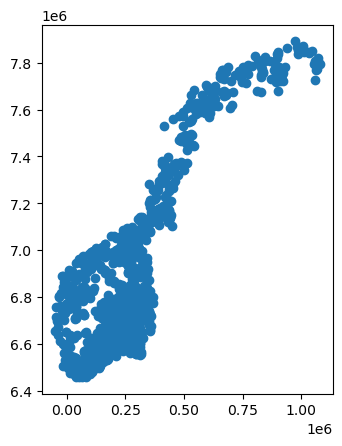

In [10]:
control_gdf.plot()

<Axes: >

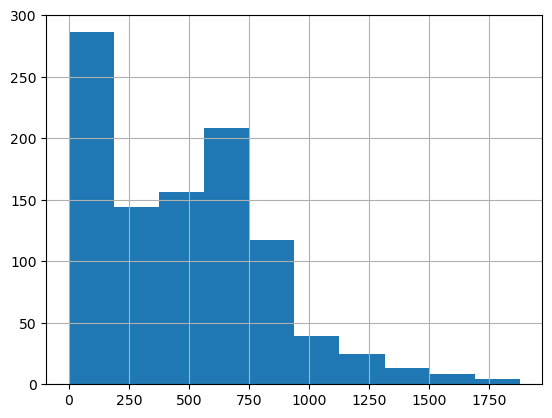

In [11]:
control_gdf['neighbor_sum'].hist()

In [17]:
adm = gpd.read_file("c:/data/Basisdata_0000_Norge_25833_Kommuner_FGDB.gdb", layer = "kommune")

In [18]:
control_gdf = control_gdf.sjoin(adm, how = 'left')

,geometry,raster_index,neighbor_sum,index_right,objtype,lokalid,navnerom,versjonid,oppdateringsdato,gyldigfra,gyldigtil,datafangstdato,datauttaksdato,opphav,kommunenummer,kommunenavn,samiskforvaltningsomrade,SHAPE_Length,SHAPE_Area
0,POINT (15368 6522200),-1781530020,347.0,111,Kommune,a850598b-bdbf-4d9c-b19a-a0bded54b92a,https://data.geonorge.no/sosi/inndelinger/innd...,7,2024-05-10 12:43:32+00:00,2024-05-10 00:00:00+00:00,NaT,NaT,2024-12-17 12:01:23+00:00,None,4228,Sirdal,0,252052.310316,1.561471e+09
1,POINT (32840 6768200),1340602618,304.0,258,Kommune,8520c379-9da9-4a14-92ad-5fd4cd6d5446,https://data.geonorge.no/sosi/inndelinger/innd...,7,2024-05-10 13:07:02+00:00,2024-05-10 00:00:00+00:00,NaT,NaT,2024-12-17 12:01:24+00:00,None,4621,Voss,0,293367.568553,2.089856e+09
2,POINT (891480 7777384),824212711,1398.0,356,Kommune,a794fe5b-51b0-418b-b0cf-e6374b0f2dce,https://data.geonorge.no/sosi/inndelinger/innd...,6,2024-05-10 15:40:33+00:00,2024-05-10 00:00:00+00:00,NaT,NaT,2024-12-17 12:01:24+00:00,None,5622,Porsanger - Porsáŋgu - Porsanki,1,340361.184652,6.012753e+09
3,POINT (178168 6665160),1831867781,622.0,89,Kommune,8dc3776b-b249-4466-a4b0-5d094edf16e4,https://data.geonorge.no/sosi/inndelinger/innd...,6,2024-05-10 15:16:54+00:00,2024-05-10 00:00:00+00:00,NaT,NaT,2024-12-17 12:01:23+00:00,None,3336,Rollag,0,100330.940712,4.500696e+08
4,POINT (604376 7623624),1557264787,306.0,43,Kommune,5e023cb4-4091-470f-82e8-21da36330201,https://data.geonorge.no/sosi/inndelinger/innd...,3,2023-11-28 17:48:17+00:00,2024-01-01 00:00:00+00:00,NaT,NaT,2024-12-17 12:01:23+00:00,None,5516,Gratangen,0,102240.415440,3.744616e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,POINT (253896 7003192),220262700,0.0,143,Kommune,778af2cb-3c48-4c6c-9841-6a35f2288fb9,https://data.geonorge.no/sosi/inndelinger/innd...,7,2024-05-10 13:27:15+00:00,2024-05-10 00:00:00+00:00,NaT,NaT,2024-12-17 12:01:23+00:00,None,5028,Melhus,0,148754.378165,6.969164e+08
996,POINT (421944 7285016),-1123357945,792.0,168,Kommune,287b1925-357d-49b5-93e4-e57f1c6c48b4,https://data.geonorge.no/sosi/inndelinger/innd...,7,2024-05-10 12:29:59+00:00,2024-05-10 00:00:00+00:00,NaT,NaT,2024-12-17 12:01:23+00:00,None,1825,Grane,0,254907.182399,2.002774e+09
997,POINT (189704 6577240),-2043929204,404.0,136,Kommune,0a9f9f05-c7d6-47fe-931a-092e93de01a5,https://data.geonorge.no/sosi/inndelinger/innd...,8,2024-05-10 15:35:55+00:00,2024-05-10 00:00:00+00:00,NaT,NaT,2024-12-17 12:01:23+00:00,None,4003,Skien,0,180978.598526,7.846551e+08
998,POINT (167848 6631304),1993279848,31.0,231,Kommune,1f2dd0c3-f6a1-4008-a0f7-e772069b7f6f,https://data.geonorge.no/sosi/inndelinger/innd...,6,2024-05-10 15:24:28+00:00,2024-05-10 00:00:00+00:00,NaT,NaT,2024-12-17 12:01:24+00:00,None,4005,Notodden,0,209997.484544,9.857216e+08


#### Analyse

In [127]:
filtered_df = (result_gdf
              .sort_values(['VitenskapligNavn', 'raster_index'])
              .drop_duplicates(subset=['VitenskapligNavn', 'raster_index'])
              .reset_index(drop=True)
              .sort_values('VitenskapligNavn')
)
filtered_df

,acceptedNameUsage,acceptedScientificName,acceptedTaxonKey,associatedOccurrences,associatedReferences,basisOfRecord,catalogNumber,class,classKey,collectionCode,...,NorskNavn,Kategori2021,EkspertGruppe,PopularNavn,VitenskapligNavn,PK_RodlistevurderingID,Tresjiktssuksesjonstilstand,Gammelskog,raster_index,neighbor_sum
0,NaN,Albatrellus citrinus Ryman,3357741.0,NaN,https://www.artsobservasjoner.no/Sighting/3573...,HUMAN_OBSERVATION,35731264,Agaricomycetes,186.0,so2-fungi,...,lammesopp,VU,Sopp,lammesopp,Albatrellus citrinus,41925,NaN,1.0,-1989692325,490.0
19,NaN,Albatrellus citrinus Ryman,3357741.0,NaN,https://www.artsobservasjoner.no/Sighting/3546...,HUMAN_OBSERVATION,35464619,Agaricomycetes,186.0,so2-fungi,...,lammesopp,VU,Sopp,lammesopp,Albatrellus citrinus,41925,NaN,1.0,1997478489,774.0
18,NaN,Albatrellus citrinus Ryman,3357741.0,NaN,https://www.artsobservasjoner.no/Sighting/3532...,HUMAN_OBSERVATION,35326182,Agaricomycetes,186.0,so2-fungi,...,lammesopp,VU,Sopp,lammesopp,Albatrellus citrinus,41925,NaN,1.0,1996639379,0.0
17,NaN,Albatrellus citrinus Ryman,3357741.0,NaN,https://www.artsobservasjoner.no/Sighting/3618...,HUMAN_OBSERVATION,36184897,Agaricomycetes,186.0,so2-fungi,...,lammesopp,VU,Sopp,lammesopp,Albatrellus citrinus,41925,NaN,1.0,1976272734,369.0
16,NaN,Albatrellus citrinus Ryman,3357741.0,NaN,https://www.artsobservasjoner.no/Sighting/3606...,HUMAN_OBSERVATION,36062175,Agaricomycetes,186.0,so2-fungi,...,lammesopp,VU,Sopp,lammesopp,Albatrellus citrinus,41925,NaN,1.0,1877716936,636.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2751,NaN,Dolichousnea longissima (Ach.) Articus,3407877.0,NaN,https://mobil.artsobservasjoner.no/sighting/34...,HUMAN_OBSERVATION,34067454,Lecanoromycetes,180.0,so2-lichens,...,huldrestry,EN,Lav,huldrestry,Usnea longissima,48115,NaN,1.0,1557716320,854.0
2749,NaN,Dolichousnea longissima (Ach.) Articus,3407877.0,NaN,https://www.artsobservasjoner.no/Sighting/3411...,HUMAN_OBSERVATION,34113004,Lecanoromycetes,180.0,so2-lichens,...,huldrestry,EN,Lav,huldrestry,Usnea longissima,48115,NaN,1.0,1141748681,770.0
2764,NaN,Dolichousnea longissima (Ach.) Articus,3407877.0,NaN,https://mobil.artsobservasjoner.no/sighting/34...,HUMAN_OBSERVATION,34056161,Lecanoromycetes,180.0,so2-lichens,...,huldrestry,EN,Lav,huldrestry,Usnea longissima,48115,NaN,1.0,1835529886,828.0
2756,NaN,Dolichousnea longissima (Ach.) Articus,3407877.0,NaN,https://mobil.artsobservasjoner.no/sighting/34...,HUMAN_OBSERVATION,34217490,Lecanoromycetes,180.0,so2-lichens,...,huldrestry,EN,Lav,huldrestry,Usnea longissima,48115,NaN,1.0,1566641795,277.0


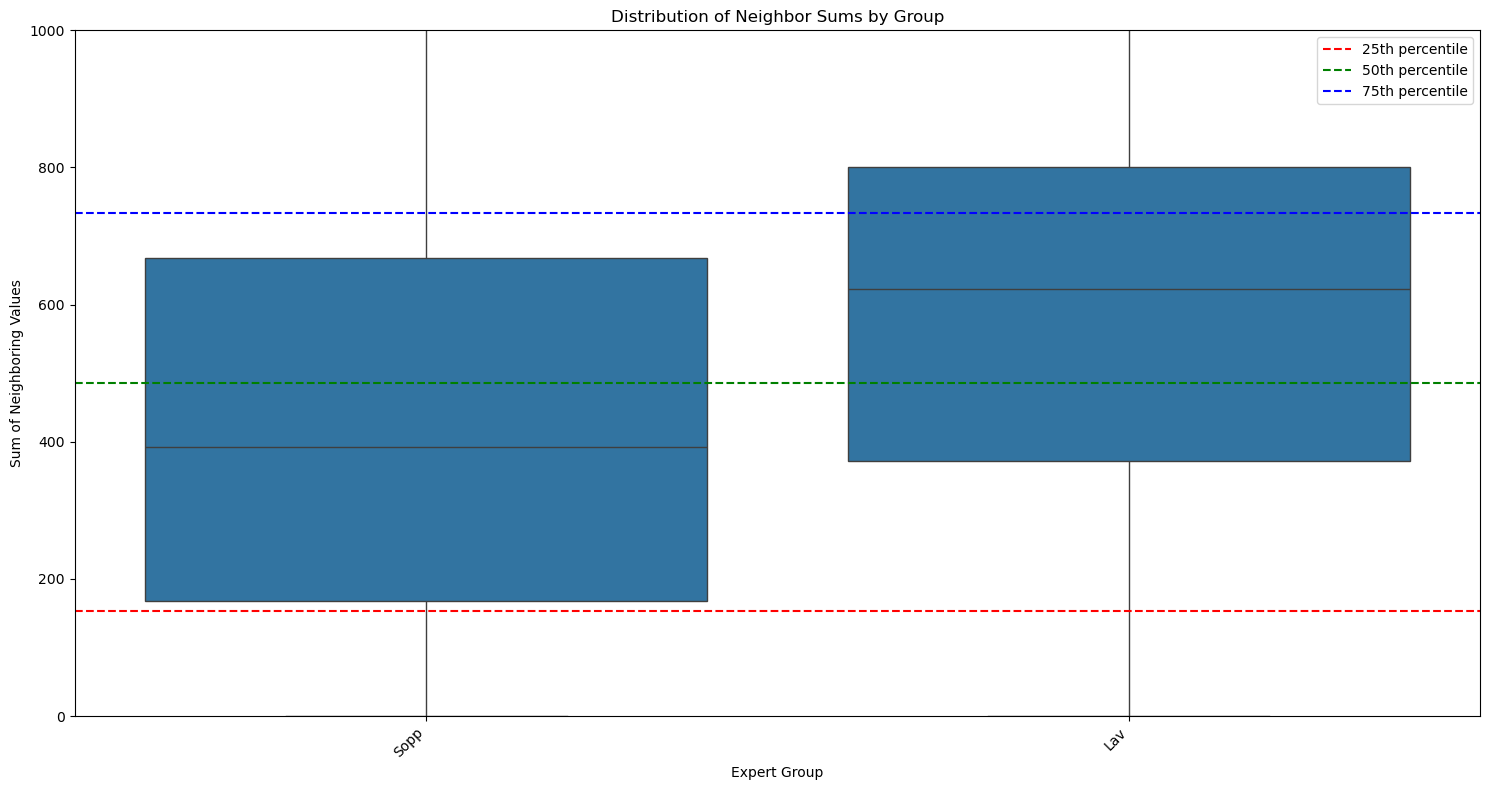

In [128]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Calculate quartiles
q25 = control_gdf['neighbor_sum'].quantile(0.25)
q50 = control_gdf['neighbor_sum'].quantile(0.50)
q75 = control_gdf['neighbor_sum'].quantile(0.75)

# Create figure
plt.figure(figsize=(15, 8))

# Create boxplot
ax = sns.boxplot(data=filtered_df, 
                 x='EkspertGruppe', 
                 y='neighbor_sum')

# Add horizontal lines
ax.axhline(y=q25, color='r', linestyle='--', label='25th percentile')
ax.axhline(y=q50, color='g', linestyle='--', label='50th percentile')
ax.axhline(y=q75, color='b', linestyle='--', label='75th percentile')

# Set y-axis limits
ax.set_ylim([0, 1000])

# Add legend
ax.legend()

# Format labels
plt.xticks(rotation=45, ha='right')
plt.xlabel('Expert Group')
plt.ylabel('Sum of Neighboring Values')
plt.title('Distribution of Neighbor Sums by Group')

plt.tight_layout()
plt.show()

In [173]:
df['l_neighbor_sum'] = np.log(df['neighbor_sum']+1)

In [ ]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pandas as pd
import numpy as np

df = filtered_df

# Clean data
df_clean = df.dropna(subset=['neighbor_sum', 'county', 'NorskNavn'])
df['class'] = df['class'].astype('category')

# Create taxonomic nested groups
df['nested_groups_tax'] = (df['kingdom'].astype(str) + '/' + 
                          df['class'].astype(str) + '/' + 
                          df['NorskNavn'].astype(str))

# Create geographic nested groups
df['nested_groups_geo'] = (df['county'].astype(str) + '/' + 
                          df['municipality'].astype(str))
df['county'] = df['county'].astype(str)
df['municipality'] = df['municipality'].astype(str)
df['NorskNavn'] = df['NorskNavn'].astype(str)
df['class'] = df['class'].astype(str)
df['kingdom'] = df['kingdom'].astype(str)

# Print data info
print("Data shape:", df.shape)
print("\nMissing values:\n", df[['county']].isnull().sum())
print("\nUnique values in groups:\n", df['NorskNavn'].nunique())


Data shape: (2766, 135)

Missing values:
 county    0
dtype: int64

Unique values in groups:
 192


In [203]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pandas as pd
import numpy as np

# Create nested group identifier
df['nested_groups'] = df['kingdom'].astype(str) + '/' + \
                     df['NorskNavn'].astype(str)

# Fit mixed model
model = smf.mixedlm(
    "l_neighbor_sum ~ 1",  # Response ~ Fixed effect
    data=df,
    groups='nested_groups',  # Random effects grouping
    re_formula="~1"
)

# Fit and summarize
result = model.fit()
print(result.summary())

# Extract random effects
print("\nRandom Effects:")
print(result.random_effects)

           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: l_neighbor_sum
No. Observations: 2766    Method:             REML          
No. Groups:       192     Scale:              2.3539        
Min. group size:  1       Log-Likelihood:     -5223.7706    
Max. group size:  20      Converged:          Yes           
Mean group size:  14.4                                      
------------------------------------------------------------
                   Coef. Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------
Intercept          5.667    0.057 99.852 0.000  5.556  5.778
nested_groups Var  0.410    0.043                           


Random Effects:
{'Fungi/almelav': nested_groups    0.375889
dtype: float64, 'Fungi/alvetrevlesopp': nested_groups    0.176646
dtype: float64, 'Fungi/bananslørsopp': nested_groups   -0.339713
dtype: float64, 'Fungi/barbarslørsopp': nested_groups   -0.383427
dtype: float64, 'Fung

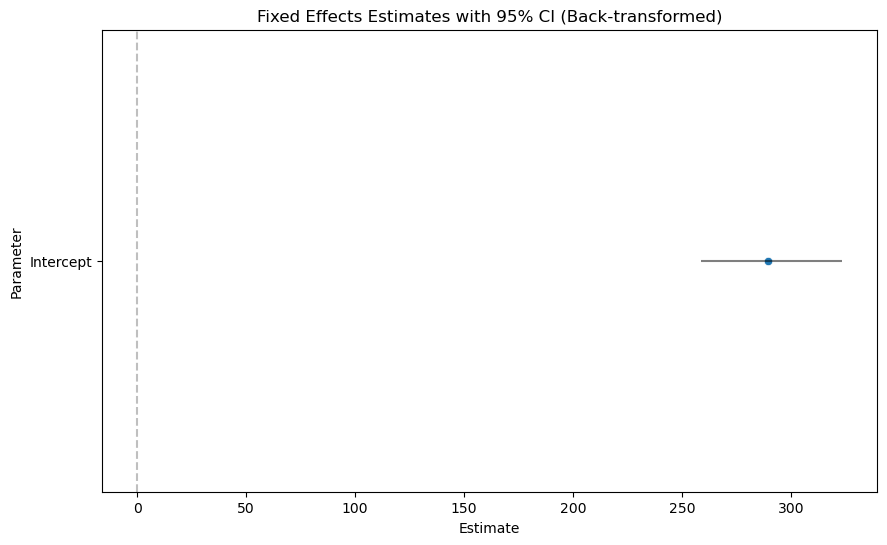

In [206]:
def plot_mixed_model_effects(result, df, log_transformed=False):
    """Plot mixed model effects with optional back-transformation for logged response"""
    
    def back_transform(x):
        return np.exp(x) if log_transformed else x
    
    # Create aligned DataFrame
    coef_data = pd.DataFrame({
        'Parameter': result.fe_params.index.to_list(),
        'Estimate': back_transform(result.fe_params),
        'CI_lower': back_transform(result.conf_int().iloc[:-1,0]),
        'CI_upper': back_transform(result.conf_int().iloc[:-1,1])
    }).reset_index(drop=True)
    
    # Create plot
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Plot coefficients
    sns.scatterplot(data=coef_data, 
                   y='Parameter', 
                   x='Estimate',
                   ax=ax)
    
    # Add error bars
    for idx, row in coef_data.iterrows():
        ax.hlines(y=row['Parameter'], 
                 xmin=row['CI_lower'], 
                 xmax=row['CI_upper'],
                 color='black',
                 alpha=0.5)
    
    ax.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
    title = 'Fixed Effects Estimates with 95% CI'
    if log_transformed:
        title += ' (Back-transformed)'
    ax.set_title(title)
    
    return fig

# Usage example:
fig = plot_mixed_model_effects(result, df, log_transformed=True)
plt.show()